In [96]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import os
import pickle
import re
from datetime import datetime as dt

from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta

from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

### Weather Data

In [2]:
with open('processed_weather.pkl', 'rb') as f:
    weather_df = pickle.load(f)

In [3]:
# Set index to measurement time and sort
weather_df = weather_df.set_index('MeasurementTime')
weather_df = weather_df.sort_index()

# Subset on 2015-2017
weather_df = weather_df[weather_df.index >= dt.strptime("2015-01-01", "%Y-%m-%d")]
weather_df = weather_df[weather_df.index < dt.strptime("2018-01-01", "%Y-%m-%d")]

# 
weather_df = weather_df[~weather_df.TempC.isna()]
weather_df = weather_df.convert_objects(convert_numeric=True)

# Fix swapped temperature columns
weather_df = weather_df.rename(columns={'TempC': 'TempF', 'TempF': 'TempC'})

# Limit index to hour
weather_df.index = pd.to_datetime(weather_df.index.strftime("%Y-%m-%d %H"))

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
def encode_weather(weather):
    
    joined = ''.join(weather).replace(',', '')
    if len(joined) == 0:
        return 'Clear'       
    else:
        heavy = re.compile('[\w\s]*heavy[\w\s]*', flags=re.I)
        moderate = re.compile('[\w\s]*(rain|snow|ice)[\w\s]*', flags=re.I)
        light = re.compile('[\w\s]*(mist|drizzle)[\w\s]*', flags=re.I)
        if len(heavy.findall(joined)) > 0:
            return 'Severe'
        elif len(moderate.findall(joined)) > 0:
            return 'Moderate'
        elif len(light.findall(joined)) > 0:
            return 'Light'
        else: 
            return 'Clear'
        
weather_df['Weather'] = weather_df.WeatherText.apply(encode_weather)

In [6]:
weather_df.head()

,ReportType,SkyConditions,Visibility,WeatherType,TempF,TempC,Humidity,WindSpeed,WindDirection,Pressure,PressureTendency,PressureChange,Precip,SkyText,WeatherText,Weather
2015-01-01 00:00:00,FM-15,SCT:04 65,10.0,NaN,22.0,-5.6,50.0,10.0,220.0,30.07,8.0,NaN,0.0,Scattered,"[, , ]",Clear
2015-01-01 01:00:00,FM-15,FEW:02 65 BKN:07 180,10.0,NaN,22.0,-5.6,50.0,10.0,230.0,30.05,NaN,NaN,0.0,Broken,"[, , ]",Clear
2015-01-01 02:00:00,FM-15,BKN:07 150 BKN:07 200,10.0,NaN,22.0,-5.6,50.0,11.0,230.0,30.03,NaN,NaN,0.0,Broken,"[, , ]",Clear
2015-01-01 03:00:00,FM-15,SCT:04 130 BKN:07 170,10.0,NaN,24.0,-4.4,46.0,13.0,240.0,30.01,6.0,NaN,0.0,Broken,"[, , ]",Clear
2015-01-01 04:00:00,FM-15,CLR:00,10.0,NaN,22.0,-5.6,52.0,15.0,230.0,30.00,NaN,NaN,0.0,Clear,"[, , ]",Clear


In [7]:
# Select columns of interest
weather_cols = ['Weather', 'TempF', 'TempC', 'WindSpeed', 'WindDirection', 'Pressure', 'Precip', ]
weather_df = weather_df[weather_cols]
weather_df.head()

,Weather,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip
2015-01-01 00:00:00,Clear,22.0,-5.6,10.0,220.0,30.07,0.0
2015-01-01 01:00:00,Clear,22.0,-5.6,10.0,230.0,30.05,0.0
2015-01-01 02:00:00,Clear,22.0,-5.6,11.0,230.0,30.03,0.0
2015-01-01 03:00:00,Clear,24.0,-4.4,13.0,240.0,30.01,0.0
2015-01-01 04:00:00,Clear,22.0,-5.6,15.0,230.0,30.00,0.0


In [8]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26285 entries, 2015-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
Weather          26285 non-null object
TempF            26282 non-null float64
TempC            26282 non-null float64
WindSpeed        26278 non-null float64
WindDirection    25924 non-null float64
Pressure         26239 non-null float64
Precip           24364 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.9+ MB


### Trip Data

In [9]:
with open('start.pkl', 'rb') as f:
    start_df = pickle.load(f)

In [10]:
# Add work day to df
start_df['WorkDay'] = (start_df.index.weekday < 6) * 1

# # Encode user type
# start_df.UserType = start_df.UserType.map({'Member': 1, 'Casual': 2})

In [11]:
def get_season(doy):
    # "day of year" ranges for the northern hemisphere
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if doy in spring:
        season = 'Spring'
    elif doy in summer:
        season = 'Summer'
    elif doy in fall:
        season = 'Fall'
    else:
        season = 'Winter'
    return season

start_df['Season'] = [get_season(xi) for xi in start_df.index.dayofyear]

In [12]:
# Add MA holidays
from workalendar.usa import Massachusetts

cal = Massachusetts()
ma_holidays = []
for yr in [2015, 2016, 2017]:
    yr_holidays = cal.holidays(yr)
    yr_holidays = [x[0] for x in yr_holidays]
    ma_holidays += yr_holidays
    
# Designate Holidays
start_df['Holiday'] = 0    
idx_date = start_df.index.date
for hdate in ma_holidays:
    idx = (idx_date == hdate)
    start_df.loc[idx, 'Holiday'] = 1

In [13]:
start_df.head()

,Duration,BikeID,UserType,BirthYear,ID,Name,Lat,Lon,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Season,Holiday
Time,,,,,,,,,,,,,,,,,,
2015-01-01 00:21:44,542,277,Member,1984,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:27:03,438,648,Member,1985,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:31:31,254,555,Member,1974,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:53:46,432,1307,Member,1987,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 01:07:06,735,177,Casual,1986,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,2015,1,1,1,1,1,3,1,Winter,1


In [14]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3627543 entries, 2015-01-01 00:21:44 to 2017-12-31 23:46:18
Data columns (total 18 columns):
Duration     int64
BikeID       int64
UserType     object
BirthYear    object
ID           int64
Name         object
Lat          float64
Lon          float64
Year         int64
Month        int64
Week         int64
Day          int64
Hour         int64
Quarter      int64
DayOfWeek    int64
WorkDay      int64
Season       object
Holiday      int64
dtypes: float64(2), int64(12), object(4)
memory usage: 685.8+ MB


### Resampling and Linking Data

#### Resample and Fix Weather Data

In [295]:
data_df = pd.concat([weather_df, pd.get_dummies(weather_df.Weather)], axis=1)
data_df.head()

,Weather,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip,Clear,Light,Moderate,Severe
2015-01-01 00:00:00,Clear,22.0,-5.6,10.0,220.0,30.07,0.0,1,0,0,0
2015-01-01 01:00:00,Clear,22.0,-5.6,10.0,230.0,30.05,0.0,1,0,0,0
2015-01-01 02:00:00,Clear,22.0,-5.6,11.0,230.0,30.03,0.0,1,0,0,0
2015-01-01 03:00:00,Clear,24.0,-4.4,13.0,240.0,30.01,0.0,1,0,0,0
2015-01-01 04:00:00,Clear,22.0,-5.6,15.0,230.0,30.00,0.0,1,0,0,0


In [296]:
# R_weather = weather_df.resample('H').mean()
# R_weather = weather_df.resample('D').mean()
# R_weather = weather_df.resample('W').mean()
R_weather = weather_df.resample('M').mean()
R_weather.head()

,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip
2015-01-31,26.263441,-3.185215,12.309140,247.345013,30.028571,0.005399
2015-02-28,19.580357,-6.897321,11.900298,258.188623,29.999388,0.006192
2015-03-31,33.006720,0.559409,11.014785,234.089674,30.015457,0.004461
2015-04-30,47.890278,8.827778,11.857741,197.211268,29.937917,0.002808
2015-05-31,61.646424,16.469501,11.009434,184.755435,30.075532,0.001697


In [297]:
R_weather.shape

(36, 6)

#### Resample and Fix Trip Data

In [298]:
data2_df = pd.concat([start_df, pd.get_dummies(start_df.UserType)], axis=1)
data2_df = pd.concat([data2_df, pd.get_dummies(start_df.Season)], axis=1)

In [299]:
data2_df

,Duration,BikeID,UserType,BirthYear,ID,Name,Lat,Lon,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Season,Holiday,Casual,Member,Fall,Spring,Summer,Winter
Time,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:21:44,542,277,Member,1984,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 00:27:03,438,648,Member,1985,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,2015,1,1,1,0,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 00:31:31,254,555,Member,1974,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,0,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 00:53:46,432,1307,Member,1987,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 01:07:06,735,177,Casual,1986,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,2015,1,1,1,1,1,3,1,Winter,1,1,0,0,0,0,1
2015-01-01 01:28:27,311,685,Member,1989,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,2015,1,1,1,1,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 01:34:54,1259,940,Member,1964,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,1,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 02:32:35,338,656,Member,1981,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2015,1,1,1,2,1,3,1,Winter,1,0,1,0,0,0,1
2015-01-01 04:41:58,429,134,Casual,1989,117,Binney St / Sixth St,42.366095,-71.086388,2015,1,1,1,4,1,3,1,Winter,1,1,0,0,0,0,1


In [300]:
# x = data2_df.BikeID.resample('H').count()
# x = data2_df.BikeID.resample('D').count()
# x = data2_df.BikeID.resample('W').count()
x = data2_df.BikeID.resample('M').count()
x.name = 'Count'
# y = data2_df.resample('H').mean()
# y = data2_df.resample('D').mean()
# y = data2_df.resample('W').mean()
y = data2_df.resample('M').mean()
y = y.drop(columns=['BikeID', 'ID', 'Lat', 'Lon', 'Casual', 'Member'])
R_trip = pd.concat([x, y], axis=1)

In [301]:
R_trip.head()

,Count,Duration,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Holiday,Fall,Spring,Summer,Winter
Time,,,,,,,,,,,,,,,
2015-01-31,7840,647.878444,2015.0,1.0,3.183546,15.993112,13.455612,1.0,2.708291,0.916709,0.058291,0.0,0.000000,0.0,1.000000
2015-02-28,4020,707.449751,2015.0,2.0,7.684577,16.867413,13.811443,1.0,3.075373,0.916915,0.002736,0.0,0.000000,0.0,1.000000
2015-03-31,11270,2234.974179,2015.0,3.0,11.851996,17.305146,13.777285,1.0,2.341171,0.921739,0.000000,0.0,0.395031,0.0,0.604969
2015-04-30,55843,983.859320,2015.0,4.0,16.748545,21.167129,13.719034,2.0,2.927314,0.877764,0.022133,0.0,1.000000,0.0,0.000000
2015-05-31,149143,1004.150661,2015.0,5.0,20.271350,15.981407,13.861033,2.0,3.081955,0.866625,0.029911,0.0,1.000000,0.0,0.000000


In [302]:
R_trip.Duration = R_trip.Duration.fillna(0)
R_trip.Year = R_trip.index.year
R_trip.Month = R_trip.index.month
R_trip.Week = R_trip.index.week
R_trip.Day = R_trip.index.day
R_trip.Hour = R_trip.index.hour
R_trip.Quarter = R_trip.index.quarter
R_trip.WorkDay = R_trip.index.weekday
R_trip.DayOfWeek = R_trip.index.dayofweek
R_trip['DayOfYear'] = R_trip.index.dayofyear
R_trip.Holiday = [get_season(xi) for xi in R_trip.index.dayofyear]

tmp = pd.get_dummies(R_trip.Holiday)
R_trip.Fall = tmp.Fall
R_trip.Spring = tmp.Spring
R_trip.Summer = tmp.Summer
R_trip.Winter = tmp.Winter
R_trip = R_trip.drop(columns='Holiday')

In [303]:
R_trip.head()

,Count,Duration,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Fall,Spring,Summer,Winter,DayOfYear
Time,,,,,,,,,,,,,,,
2015-01-31,7840,647.878444,2015,1,5,31,0,1,5,5,0,0,0,1,31
2015-02-28,4020,707.449751,2015,2,9,28,0,1,5,5,0,0,0,1,59
2015-03-31,11270,2234.974179,2015,3,14,31,0,1,1,1,0,1,0,0,90
2015-04-30,55843,983.859320,2015,4,18,30,0,2,3,3,0,1,0,0,120
2015-05-31,149143,1004.150661,2015,5,22,31,0,2,6,6,0,1,0,0,151


#### Combine Data

In [304]:
data_df = pd.concat([R_trip, R_weather], axis=1)

In [305]:
data_df.head()

,Count,Duration,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Fall,Spring,Summer,Winter,DayOfYear,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-31,7840,647.878444,2015,1,5,31,0,1,5,5,0,0,0,1,31,26.263441,-3.185215,12.309140,247.345013,30.028571,0.005399
2015-02-28,4020,707.449751,2015,2,9,28,0,1,5,5,0,0,0,1,59,19.580357,-6.897321,11.900298,258.188623,29.999388,0.006192
2015-03-31,11270,2234.974179,2015,3,14,31,0,1,1,1,0,1,0,0,90,33.006720,0.559409,11.014785,234.089674,30.015457,0.004461
2015-04-30,55843,983.859320,2015,4,18,30,0,2,3,3,0,1,0,0,120,47.890278,8.827778,11.857741,197.211268,29.937917,0.002808
2015-05-31,149143,1004.150661,2015,5,22,31,0,2,6,6,0,1,0,0,151,61.646424,16.469501,11.009434,184.755435,30.075532,0.001697


In [306]:
data_df.Precip = data_df.Precip.fillna(data_df.Precip.mean())
data_df.TempC = data_df.TempC.fillna(data_df.TempC.mean())
data_df.WindSpeed = data_df.WindSpeed.fillna(data_df.WindSpeed.mean())
data_df.Pressure = data_df.Pressure.fillna(data_df.Pressure.mean())

In [307]:
data_df.head()

,Count,Duration,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Fall,Spring,Summer,Winter,DayOfYear,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-31,7840,647.878444,2015,1,5,31,0,1,5,5,0,0,0,1,31,26.263441,-3.185215,12.309140,247.345013,30.028571,0.005399
2015-02-28,4020,707.449751,2015,2,9,28,0,1,5,5,0,0,0,1,59,19.580357,-6.897321,11.900298,258.188623,29.999388,0.006192
2015-03-31,11270,2234.974179,2015,3,14,31,0,1,1,1,0,1,0,0,90,33.006720,0.559409,11.014785,234.089674,30.015457,0.004461
2015-04-30,55843,983.859320,2015,4,18,30,0,2,3,3,0,1,0,0,120,47.890278,8.827778,11.857741,197.211268,29.937917,0.002808
2015-05-31,149143,1004.150661,2015,5,22,31,0,2,6,6,0,1,0,0,151,61.646424,16.469501,11.009434,184.755435,30.075532,0.001697


In [308]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2015-01-31 to 2017-12-31
Freq: M
Data columns (total 21 columns):
Count            36 non-null int64
Duration         36 non-null float64
Year             36 non-null int64
Month            36 non-null int64
Week             36 non-null int64
Day              36 non-null int64
Hour             36 non-null int64
Quarter          36 non-null int64
DayOfWeek        36 non-null int64
WorkDay          36 non-null int64
Fall             36 non-null uint8
Spring           36 non-null uint8
Summer           36 non-null uint8
Winter           36 non-null uint8
DayOfYear        36 non-null int64
TempF            36 non-null float64
TempC            36 non-null float64
WindSpeed        36 non-null float64
WindDirection    36 non-null float64
Pressure         36 non-null float64
Precip           36 non-null float64
dtypes: float64(7), int64(10), uint8(4)
memory usage: 6.5 KB


### SARIMAX with StatsModels

In [309]:
endog = data_df.Count
exog = data_df[['TempC','WindSpeed','Precip']]
exog = sm.tools.add_constant(exog)

In [310]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2015-01-31 to 2017-12-31
Freq: M
Data columns (total 4 columns):
const        36 non-null float64
TempC        36 non-null float64
WindSpeed    36 non-null float64
Precip       36 non-null float64
dtypes: float64(4)
memory usage: 1.4 KB


                                 Statespace Model Results                                 
Dep. Variable:                              Count   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -260.981
Date:                            Thu, 29 Mar 2018   AIC                            535.962
Time:                                    22:36:55   BIC                            547.047
Sample:                                01-31-2015   HQIC                           539.831
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1530.7857   3725.538      0.411      0.681   -5771.136    8832.707
const       7.976e-06   2.42e+05   

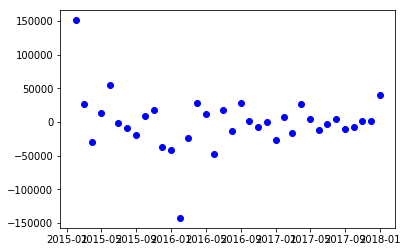

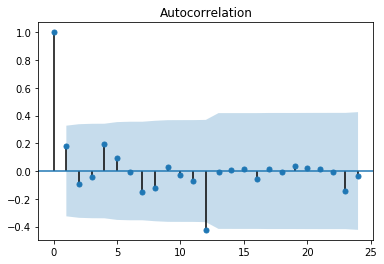

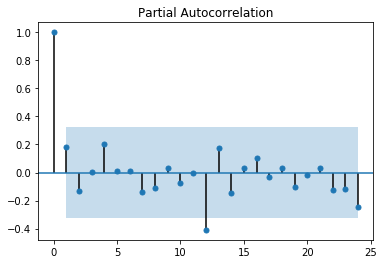

In [336]:
# # Day
# sarima_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(0,1,4), seasonal_order=(0,1,4,7), trend='c').fit()
# # Week
# sarima_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1), seasonal_order=(1,1,0,52), trend='c').fit()
# Month
sarima_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(0,1,1), seasonal_order=(0,1,0,12), trend='c').fit()

print(sarima_mod.summary())

plt.plot(sarima_mod.resid, "bo")
# # Day
# print(plot_acf(sarima_mod.resid, lags=100))
# print(plot_pacf(sarima_mod.resid, lags=100))
# # Week
# print(plot_acf(sarima_mod.resid, lags=104))
# print(plot_pacf(sarima_mod.resid, lags=104))
# Month
print(plot_acf(sarima_mod.resid, lags=24))
print(plot_pacf(sarima_mod.resid, lags=24))

In [337]:
#turn weekly series into dataframe and add prediction column
df_day = endog.to_frame()
df_day.rename(columns={"BikeID" : "Count"}, inplace=True)

In [338]:
def bound_prediction(predict):
    predict[predict < 0] = 0
    return predict

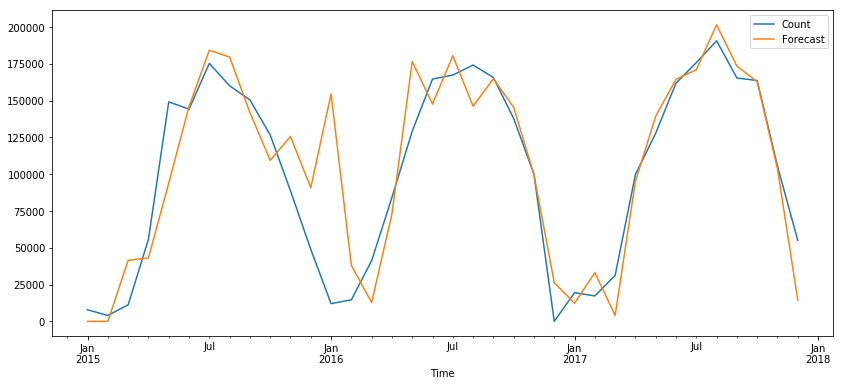

In [339]:
#plot weekly actual and forecast
df_day['Forecast'] = bound_prediction(sarima_mod.predict())
df_day
df_day.plot(figsize=(14, 6));

In [249]:
#add daily dates to df_day
start = dt.strptime("2018-01-01", "%Y-%m-%d")
day_list = [start + relativedelta(days=x) for x in range(0,365)]
future_day = pd.DataFrame(index=day_list, columns= df_day.columns)
df_day = pd.concat([df_day, future_day])

In [250]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-01 to 2018-12-31
Data columns (total 2 columns):
Count       1096 non-null object
Forecast    1096 non-null float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


In [254]:
start_idx = 1096
future_days = 30
end_idx = start_idx+future_days
df_day['Forecast'] = bound_prediction(sarima_mod.predict(start=start_idx, end=end_idx, dynamic=True))
df_day
df_day.plot(figsize=(14, 6));

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

### With Prophet